In [75]:
from random import choices

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("../df_approx_windows.csv")

In [3]:
df.shape

(48675846, 7)

In [4]:
df.head()

,ts_name,type,fhat,PSD,freq,freq_apx_idx,freq_apx
0,H101,fft,1.669116e+06,3.979926e+09,0.000000,0,0.000000
1,H101,fft,6.368073e+03,5.793194e+04,1.428571,119,1.458190
2,H101,fft,2.309107e+04,7.617110e+05,2.857143,149,2.865581
3,H101,fft,2.112334e+04,6.374224e+05,4.285714,167,4.297856
4,H101,fft,9.239087e+03,1.219439e+05,5.714286,180,5.759585


In [8]:
ts = choices(df['ts_name'].unique(), k=10)

In [9]:
ts

['M36203',
 'M30964',
 'Y21109',
 'M13267',
 'Q19803',
 'M10540',
 'M16041',
 'M25917',
 'M6479',
 'M7019']

In [19]:
df_tmp = df[(df['ts_name']=='M36203') &
  (df['type']=='Welch')]

In [27]:
df_tmp.sort_values(by='PSD', ascending=False)[:4]['freq_apx_idx'].to_list()

[16, 0, 47, 65]

In [5]:
df_test = df[:10000]

In [22]:
names = []
types = []
freqs = []


for elm in tqdm(df.groupby(['ts_name', 'type'])):
    names.append(elm[0][0])
    types.append(elm[0][1])
    
    df_sub = elm[1]
    df_sub.sort_values("PSD", ascending=False, inplace=True)
    freqs.append(df_sub[:5]['freq_apx_idx'].to_list())

df_reduced = pd.DataFrame({
    'ts_name': names,
    'type': types,
    'freqs': freqs
})

  0%|          | 0/300000 [00:00<?, ?it/s]

In [24]:
df_reduced.to_csv("../df_top_5_freq_windows.csv")

In [61]:
df_test = df_reduced[:9]

In [60]:
df_test

,ts_name,type,freqs
0,D1,Hamming,"[0, 102, 409, 409, 133]"
1,D1,Welch,"[0, 0, 0, 0, 0]"
2,D1,fft,"[0, 102, 409, 133, 409]"
3,D10,Hamming,"[0, 120, 409, 151, 409]"
4,D10,Welch,"[0, 0, 0, 0, 9]"
5,D10,fft,"[0, 151, 409, 409, 182]"
6,D100,Hamming,"[0, 102, 409, 133, 409]"
7,D100,Welch,"[0, 0, 0, 0, 0]"
8,D100,fft,"[0, 102, 409, 151, 409]"
9,D1000,Hamming,"[0, 100, 409, 131, 409]"


In [71]:
names = []
types = []
match_ratios = []

for elm in tqdm(df_reduced.groupby("ts_name")):
    name=elm[0]
    df_sub = elm[1]
    # generate arrays for matching freqs
    freqs_fft = np.array(df_sub.loc[df_sub['type']=='fft', 'freqs'].reset_index(drop=True)[0])
    freqs_hamming = np.array(df_sub.loc[df_sub['type']=='Hamming', 'freqs'].reset_index(drop=True)[0])
    freqs_welch = np.array(df_sub.loc[df_sub['type']=='Welch', 'freqs'].reset_index(drop=True)[0])  
    
    # create matching frequ
    match_fft_hamming = np.sum((freqs_fft == freqs_hamming))/len(freqs_fft)
    match_fft_welch = np.sum((freqs_fft == freqs_welch))/len(freqs_fft)
    match_hamming_welch = np.sum((freqs_hamming == freqs_welch))/len(freqs_hamming)
    
    # generate data
    names.extend([name]*3)
    types.extend(['fft_hamming', 'fft_welch', 'hamming_welch'])
    match_ratios.extend([match_fft_hamming, match_fft_welch, match_hamming_welch])

df_match = pd.DataFrame({
    'ts_name': names,
    'type': types,
    'match_ratio': match_ratios
})
df_match.head()

  0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-71-274b01a6613f>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  match_fft_welch = np.sum((freqs_fft == freqs_welch))/len(freqs_fft)
<ipython-input-71-274b01a6613f>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  match_hamming_welch = np.sum((freqs_hamming == freqs_welch))/len(freqs_hamming)


,ts_name,type,match_ratio
0,D1,fft_hamming,0.6
1,D1,fft_welch,0.2
2,D1,hamming_welch,0.2
3,D10,fft_hamming,0.4
4,D10,fft_welch,0.2


In [72]:
df_match.shape

(300000, 3)

In [74]:
df_match.head()

,ts_name,type,match_ratio
0,D1,fft_hamming,0.6
1,D1,fft_welch,0.2
2,D1,hamming_welch,0.2
3,D10,fft_hamming,0.4
4,D10,fft_welch,0.2


In [77]:
df_match[df_match['type']=='fft_hamming']['match_ratio']

0         0.6
3         0.4
6         0.8
9         0.8
12        0.4
         ... 
299985    0.2
299988    0.6
299991    0.6
299994    0.6
299997    0.6
Name: match_ratio, Length: 100000, dtype: float64

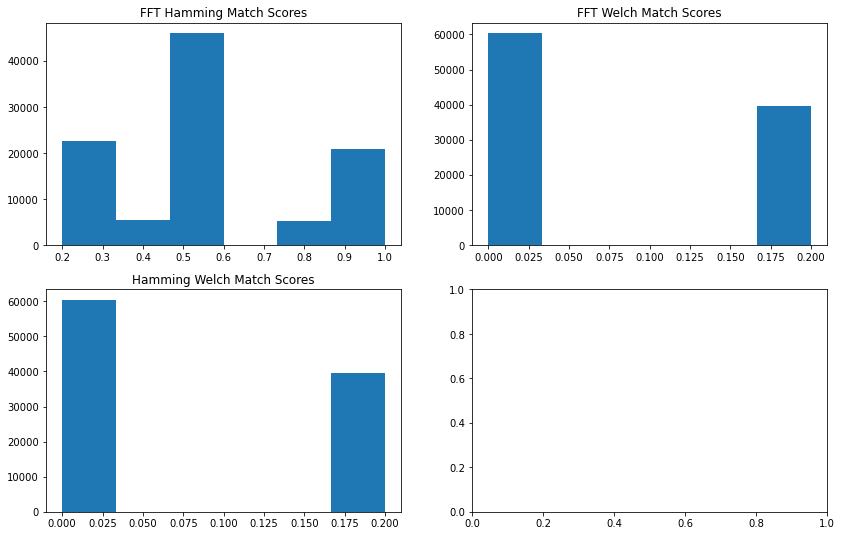

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(14,9))

axs.flatten()[0].hist(df_match[df_match['type']=='fft_hamming']['match_ratio'], bins=6)
axs.flatten()[0].title.set_text("FFT Hamming Match Scores")
axs.flatten()[1].hist(df_match[df_match['type']=='fft_welch']['match_ratio'], bins=6)
axs.flatten()[1].title.set_text("FFT Welch Match Scores")

axs.flatten()[2].hist(df_match[df_match['type']=='hamming_welch']['match_ratio'], bins=6)
axs.flatten()[2].title.set_text("Hamming Welch Match Scores")
